In [29]:
%matplotlib inline

import pandas as pd
import numpy as np
from sklearn import preprocessing
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [8, 6]
plt.rcParams['figure.dpi'] = 80
# 
# %matplotlib notebook

from datetime import datetime, timedelta
from sklearn.preprocessing import FunctionTransformer
import statsmodels.api as sm
from statsmodels.tsa.stattools import acf, pacf

In [2]:
data = pd.read_csv('hotel.csv')
print('\n Data Types:')
print(data.dtypes)
data.head()


 Data Types:
订单号      object
酒店名称     object
入离日期     object
入住房型     object
间夜        int64
订单底价    float64
状态       object
dtype: object


,订单号,酒店名称,入离日期,入住房型,间夜,订单底价,状态
0,124764849,天邸酒店,2016-08-27~2016-08-28,特惠房,1,405.0,已确认
1,143007017,天邸酒店,2016-09-16~2016-09-17,特惠房,1,259.2,已确认
2,310259623,深圳大鹏天邸酒店,2017-04-03~2017-04-04,豪华双床房,2,810.0,已确认
3,310287128,深圳大鹏天邸酒店,2017-04-03~2017-04-04,豪华双床房,1,405.0,已确认
4,332956544,深圳大鹏天邸酒店,2017-04-26~2017-04-27,豪华大床房,1,405.0,已确认


In [3]:
# split dates
data[['checkin','checkout']] = pd.DataFrame(data.入离日期.str.split('~',1).tolist(),
                                   columns = ['flips','row'])
data.checkin = pd.to_datetime(data.checkin)
data.checkout = pd.to_datetime(data.checkout)
data = data.drop('入离日期',axis=1)
data['ds'] = (data.checkout - data.checkin)/timedelta(days=1)

data.head()

,订单号,酒店名称,入住房型,间夜,订单底价,状态,checkin,checkout,ds
0,124764849,天邸酒店,特惠房,1,405.0,已确认,2016-08-27,2016-08-28,1.0
1,143007017,天邸酒店,特惠房,1,259.2,已确认,2016-09-16,2016-09-17,1.0
2,310259623,深圳大鹏天邸酒店,豪华双床房,2,810.0,已确认,2017-04-03,2017-04-04,1.0
3,310287128,深圳大鹏天邸酒店,豪华双床房,1,405.0,已确认,2017-04-03,2017-04-04,1.0
4,332956544,深圳大鹏天邸酒店,豪华大床房,1,405.0,已确认,2017-04-26,2017-04-27,1.0


In [4]:
# data.酒店名称.value_counts()

In [5]:
data = data[data.酒店名称 == '首信大酒店']

In [6]:
# groupby day
df = data.groupby(['checkin']).agg({'订单底价':'mean',      
                                     '间夜': "sum",
                                     }) 
df = df['2016-05-15':'2018-04-12']
df = df.astype('float').round(2)
df.columns = ['mean_price', 'total_roomsNight']
df.tail()

,mean_price,total_roomsNight
checkin,,
2018-04-08,151.70,5.0
2018-04-09,189.11,7.0
2018-04-10,174.71,10.0
2018-04-11,175.80,11.0
2018-04-12,224.84,10.0


In [7]:
ts = df[['mean_price']]
ts.head(2)

,mean_price
checkin,
2016-08-20,171.77
2016-08-21,182.70


In [8]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(window=12).mean()
    rolstd = timeseries.rolling(window=12).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries.iloc[:,0].values, autolag='AIC' )
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

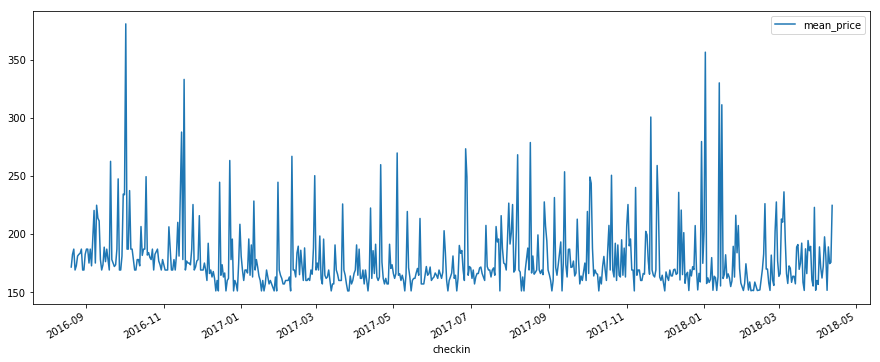

In [9]:
ts.plot(figsize=(15,6))

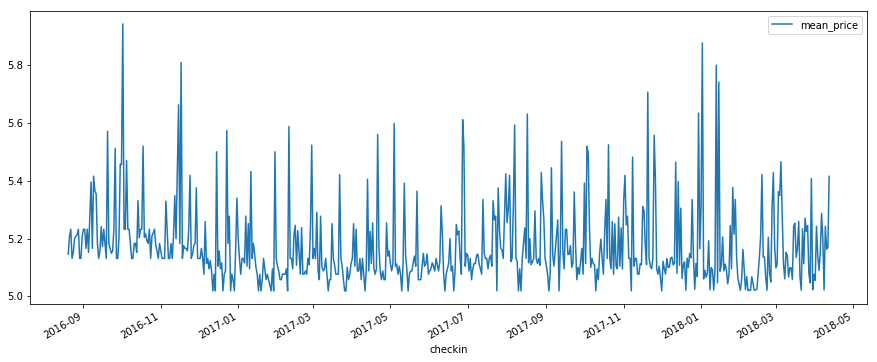

In [10]:
ts_log = np.log(ts)
ts_log.plot(figsize=(15,6))

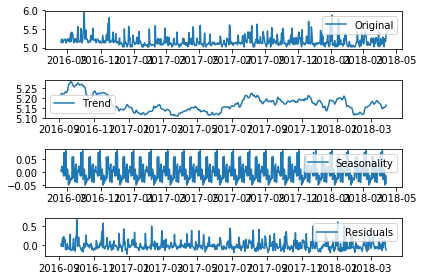

In [20]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log,freq=30)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

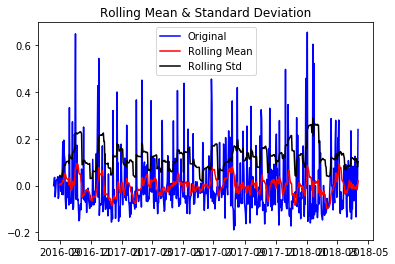

Results of Dickey-Fuller Test:
Test Statistic                -1.545209e+01
p-value                        2.775603e-28
#Lags Used                     1.000000e+00
Number of Observations Used    5.850000e+02
Critical Value (1%)           -3.441578e+00
Critical Value (5%)           -2.866493e+00
Critical Value (10%)          -2.569408e+00
dtype: float64


In [14]:
ts_log_ewma_diff = ts_log - expwighted_avg
test_stationarity(ts_log_ewma_diff)

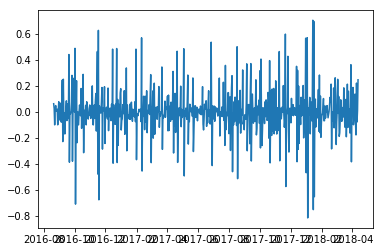

In [15]:
ts_log_diff = ts_log - ts_log.shift()
plt.plot(ts_log_diff)

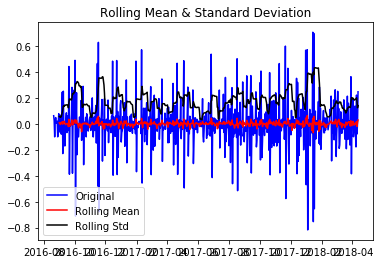

Results of Dickey-Fuller Test:
Test Statistic                -9.655333e+00
p-value                        1.399089e-16
#Lags Used                     1.900000e+01
Number of Observations Used    5.660000e+02
Critical Value (1%)           -3.441956e+00
Critical Value (5%)           -2.866660e+00
Critical Value (10%)          -2.569497e+00
dtype: float64


In [16]:
ts_log_diff.dropna(inplace=True)
test_stationarity(ts_log_diff)

In [40]:
lag_acf = acf(ts_log_diff, nlags=20)
lag_pacf = pacf(ts_log_diff, nlags=20, method='ols')

Text(0.5,1,'Autocorrelation Function')

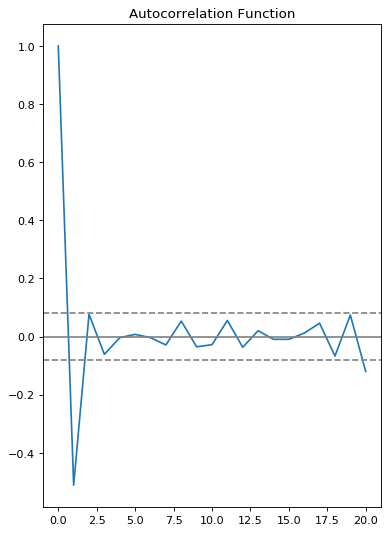

In [41]:
#Plot ACF: 
fig = plt.figure(figsize=(12,8))
plt.subplot(121) 
plt.plot(lag_acf)
plt.axhline(y=0,color='gray') # linestyle='--',
plt.axhline(y=-1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')

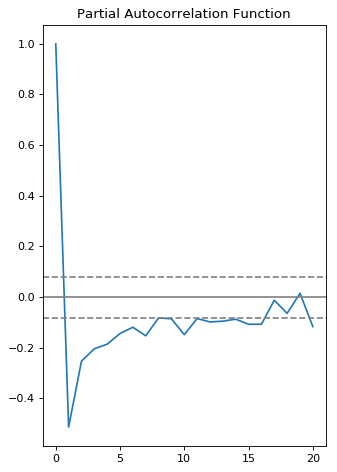

In [42]:
#Plot PACF:
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,color='gray') # linestyle='--',
plt.axhline(y=-1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()

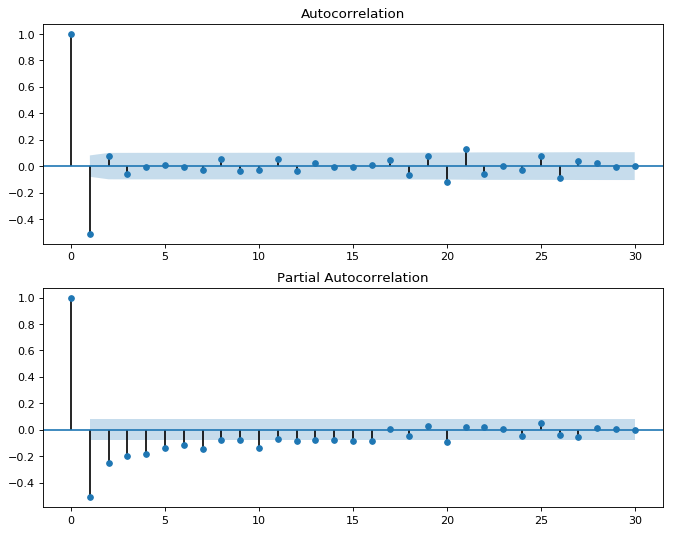

In [43]:
# fig = plt.figure(figsize=(10,8))
# ax1 = fig.add_subplot(211)
# fig = sm.graphics.tsa.plot_acf(ts_log_diff.values.squeeze(), lags=30, ax=ax1)
# ax2 = fig.add_subplot(212)
# fig = sm.graphics.tsa.plot_pacf(ts_log_diff, lags=30, ax=ax2)

/anaconda3/envs/ml/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:646: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):
/anaconda3/envs/ml/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:650: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  elif issubdtype(paramsdtype, complex):
/anaconda3/envs/ml/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:577: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):


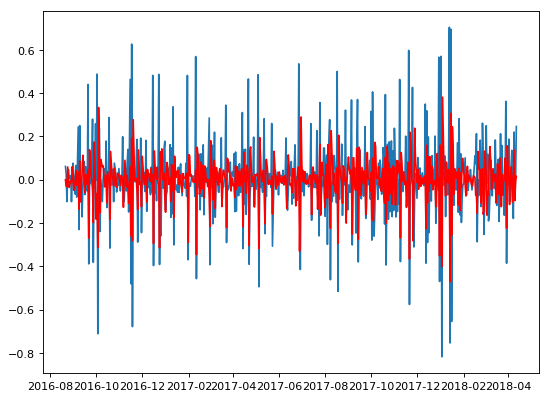

In [56]:
from statsmodels.tsa.arima_model import ARIMA
model = ARIMA(ts_log, order=(2, 1, 0))  
results_AR = model.fit(disp=-1)  
plt.plot(ts_log_diff)
plt.plot(results_AR.fittedvalues, color='red')
# plt.title('RSS: %.4f'% sum((results_AR.fittedvalues-ts_log_diff)**2))

/anaconda3/envs/ml/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:646: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):
/anaconda3/envs/ml/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:650: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  elif issubdtype(paramsdtype, complex):
/anaconda3/envs/ml/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:577: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):


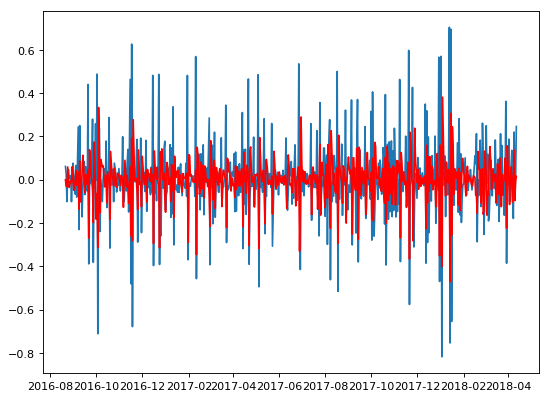

In [57]:
model1 = ARIMA(ts_log, order=(0, 1, 2))  
results_MA = model1.fit(disp=-1)  
plt.plot(ts_log_diff)
plt.plot(results_MA.fittedvalues, color='red')
# plt.title('RSS: %.4f'% sum((results_MA.fittedvalues-ts_log_diff)**2))

/anaconda3/envs/ml/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:646: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):
/anaconda3/envs/ml/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:650: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  elif issubdtype(paramsdtype, complex):
/anaconda3/envs/ml/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:577: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):


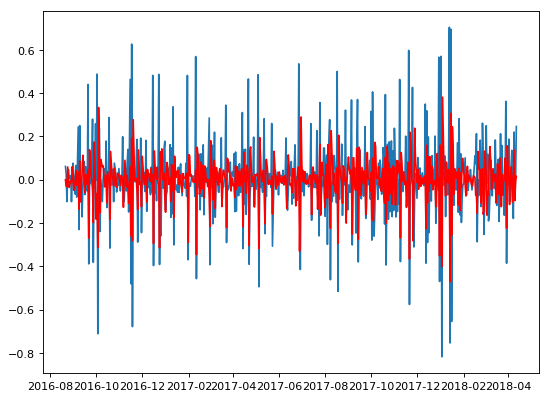

In [58]:
model2 = ARIMA(ts_log, order=(2, 1, 2))  
results_ARIMA = model2.fit(disp=-1)  
plt.plot(ts_log_diff)
plt.plot(results_ARIMA.fittedvalues, color='red')
# plt.title('RSS: %.4f'% sum((results_ARIMA.fittedvalues-ts_log_diff)**2))

In [59]:
predictions_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues, copy=True)
print(predictions_ARIMA_diff.head())

checkin
2016-08-21    0.000205
2016-08-22   -0.031315
2016-08-23   -0.030785
2016-08-24    0.059149
2016-08-25    0.012364
dtype: float64


In [61]:
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
print(predictions_ARIMA_diff_cumsum.head())

checkin
2016-08-21    0.000205
2016-08-22   -0.031110
2016-08-23   -0.061895
2016-08-24   -0.002746
2016-08-25    0.009617
dtype: float64


In [62]:
predictions_ARIMA_log = pd.Series(ts_log.ix[0], index=ts_log.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum,fill_value=0)
predictions_ARIMA_log.head()

checkin
2016-08-20         NaN
2016-08-21    0.000205
2016-08-22   -0.031110
2016-08-23   -0.061895
2016-08-24   -0.002746
dtype: float64

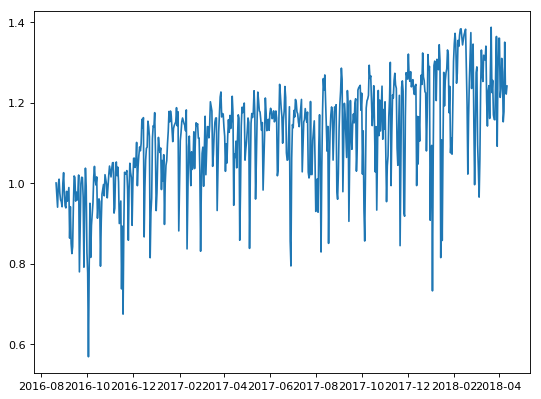

In [64]:
predictions_ARIMA = np.exp(predictions_ARIMA_log)
plt.plot(ts)
plt.plot(predictions_ARIMA)
# plt.title('RMSE: %.4f'% np.sqrt(sum((predictions_ARIMA-ts)**2)/len(ts)))

In [ ]:

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
import warnings
from pandas import Series
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
from math import sqrt
 
# evaluate an ARIMA model for a given order (p,d,q) and return RMSE
def evaluate_arima_model(X, arima_order):
	# prepare training dataset
	X = X.astype('float32')
	train_size = int(len(X) * 0.50)
	train, test = X[0:train_size], X[train_size:]
	history = [x for x in train]
	# make predictions
	predictions = list()
	for t in range(len(test)):
		model = ARIMA(history, order=arima_order)
		model_fit = model.fit(disp=0)
		yhat = model_fit.forecast()[0]
		predictions.append(yhat)
		history.append(test[t])
	# calculate out of sample error
	mse = mean_squared_error(test, predictions)
	rmse = sqrt(mse)
	return rmse
 
# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(dataset, p_values, d_values, q_values):
	dataset = dataset.astype('float32')
	best_score, best_cfg = float("inf"), None
	for p in p_values:
		for d in d_values:
			for q in q_values:
				order = (p,d,q)
				try:
					mse = evaluate_arima_model(dataset, order)
					if mse < best_score:
						best_score, best_cfg = mse, order
					print('ARIMA%s MSE=%.3f' % (order,mse))
				except:
					continue
	print('Best ARIMA%s MSE=%.3f' % (best_cfg, best_score))
 

# load dataset

# evaluate parameters
p_values = range(0,13)
d_values = range(0, 4)
q_values = range(0, 13)
warnings.filterwarnings("ignore")
evaluate_models(ts.values, p_values, d_values, q_values)

ARIMA(0, 0, 0) MSE=30.176
ARIMA(0, 0, 1) MSE=30.194
ARIMA(0, 0, 2) MSE=30.285
ARIMA(0, 0, 3) MSE=30.343
ARIMA(0, 0, 4) MSE=30.419
ARIMA(0, 0, 5) MSE=30.450
ARIMA(0, 0, 6) MSE=30.505
ARIMA(0, 0, 7) MSE=30.535
ARIMA(0, 0, 8) MSE=30.604
ARIMA(0, 0, 9) MSE=30.601
ARIMA(0, 0, 10) MSE=30.657
ARIMA(0, 0, 11) MSE=30.686
